## Intensity filtered data using reference aluminium wavelength 309.506 (pixel number 445) using saturated data


In [1]:
import os
from sys import stdout
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
import scipy.io
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [6]:
x_df = pd.read_csv('../avg_base_wl_basic_28-02.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(34, 3648)
(3648,)
34


216.330000  216.370000  216.410000  216.450000  216.490000  216.520000  \
0   -34.080506  -52.856238  -53.531268  -50.722102  -46.480848  -48.353168   
1   -35.618919  -60.499509  -60.724984  -58.526364  -52.552160  -54.819421   
2   -62.382227  -84.498001  -82.950714  -81.565761  -74.436931  -77.430743   
3   -49.101504  -80.148716  -83.607070  -77.709286  -63.839702  -69.958822   
4   -35.597277  -58.723867  -60.834177  -57.003971  -51.635249  -52.753055   
5   -36.534193  -59.580579  -59.810637  -55.192681  -50.080626  -51.567380   
6   -37.056010  -62.295118  -62.219335  -58.452735  -52.370099  -54.861897   
7   -36.567012  -60.525560  -61.558858  -60.930587  -51.995660  -56.664018   
8   -36.352760  -66.482287  -70.130211  -67.015686  -56.367065  -60.704904   
9   -31.922748  -51.175660  -52.985698  -47.869829  -44.266964  -45.152212   
10  -44.853878  -77.363471  -77.828906  -74.245638  -62.899375  -66.801152   
11  -56.049767  -85.316034  -88.122173  -85.360525  -71.298230  -78.835602   
12  -37.110913  -54.480085  -52.202878  -50.244582  -49.938695  -49.494972   
13  -59.504080  -73.812557  -70.581533  -71.401440  -66.797223  -64.741849   
14  -43.141050  -56.757398  -56.340484  -53.668082  -50.214357  -46.846963   
15  -42.234265  -59.352397  -57.835929  -53.295594  -51.225052  -44.751816   
16  -53.388363  -69.857963  -68.749905  -64.348927  -63.266063  -61.255393   
17  -30.921968  -45.458906  -44.618564  -42.942566  -42.509506  -41.698804   
18  -46.051061  -61.081730  -59.844707  -58.175975  -54.435378  -55.071621   
19  -40.437569  -53.368599  -52.354001  -51.883608  -48.535669  -48.041620   
20  -64.492851  -79.491338  -80.066391  -78.427537  -76.790618  -75.984507   
21 -103.064140 -120.225521 -117.851821 -117.778948 -114.048511 -111.152773   
22  -18.635485  -33.116267  -31.251134  -28.115578  -27.840168  -27.825272   
23  -32.922595  -46.451284  -45.394735  -42.497556  -42.445572  -42.489595   
24  -67.813804 -100.379079 -101.077468  -97.335196  -78.678817  -84.724059   
25   -6.654355  -21.944984  -22.569564  -18.818758  -18.679576  -18.564510   
26  -12.881659  -27.042398  -27.585504  -24.188559  -22.413778  -24.349320   
27  -52.903696  -74.352399  -74.569024  -71.240239  -63.750533  -66.619816   
28  -10.935745  -25.815226  -23.347346  -21.923796  -21.830210  -22.206879   
29  -12.376573  -23.880609  -22.305571  -19.606871  -20.804125  -19.283183   
30  -27.439976  -41.701398  -41.046564  -37.476566  -39.168742  -38.627195   
31  -20.311666  -30.870419  -32.010735  -26.673577  -26.759513  -29.322398   
32  -27.951139  -40.765102  -42.007698  -38.803172  -39.475254  -38.331336   
33  -14.028450  -26.875373  -26.673201  -21.852423  -23.301410  -24.719901   

    216.560000  216.600000  216.640000  216.680000  ...  340.120000  \
0   -43.511188  -42.930313  -25.964166  -13.178900  ... -103.397082   
1   -50.428250  -48.202075  -29.373010   -7.262829  ...  -65.223663   
2   -70.423088  -64.868505  -43.506519  -21.451839  ...  -93.318483   
3   -68.338852  -63.386695  -29.598815   21.239889  ...  -42.188972   
4   -50.356131  -46.890307  -24.775737    3.372683  ...  -72.327183   
5   -51.542303  -46.489816  -26.755774   -1.753168  ...  -85.625283   
6   -52.544780  -48.673733  -25.452400    4.840277  ...  -76.810026   
7   -52.716117  -49.237293  -25.918533    0.284314  ...  -81.835294   
8   -57.048680  -55.251739  -29.179874   -1.546280  ...  -79.287743   
9   -43.333262  -39.709429  -22.070866    0.327345  ...  -78.304219   
10  -64.706805  -58.911782  -25.695943   22.637475  ...  -86.845884   
11  -75.357003  -69.306601  -39.904484    0.075839  ...  -90.194816   
12  -42.139263  -41.144701  -33.557053  -39.324000  ...  -59.646484   
13  -55.505581  -51.229265  -45.902495  -55.733682  ... -104.941694   
14  -32.155422  -20.055507  -17.825345  -32.797555  ...  -54.450492   
15  -30.240532  -18.841084  -16.518416  -34.284452  ... -122.993509   
16  -51.983805  -42.550746  -38.437816  -48.449501  ...  -82.71248

[[216.33]
 [216.37]
 [216.41]
 ...
 [340.32]
 [340.34]
 [340.37]]


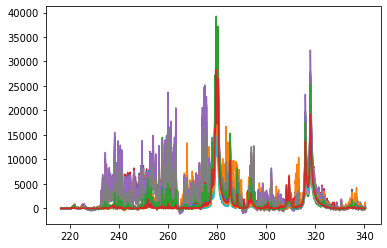

In [7]:
#This is just for visualizing the various plots of the samples

mat = scipy.io.loadmat("../data/H01.mat")
wl= mat["wl"]
print(wl)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""




In [8]:
df_y = pd.read_csv('../concentration.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(34, 12)


Sample   CaO  CaF2    MgO  Al2O3   SiO2    FeO   MnO  Cr2O3  P2O5  V2O5  \
0     H01  37.8  0.18  25.00   9.61  13.20  18.30  1.99   0.20  0.23  0.18   
1     H02  44.5  0.22  18.00   5.04  14.20  18.90  2.10   0.28  0.26  0.06   
2     H03  38.5  0.22  21.10   6.14  10.60  20.20  5.82   0.61  0.40  0.14   
3     H04  38.4  0.04  15.50   4.07  12.80  26.70  3.35   0.52  0.31  0.08   
4     H05  43.2  0.18  17.10   4.14  14.80  21.70  1.72   0.20  0.29  0.18   
5     H06  45.3  0.23  15.90   4.34  16.50  18.90  1.29   0.10  0.30  0.11   
6     H07  46.1  0.25  14.30   4.12  16.20  19.00  1.21   0.09  0.27  0.06   
7     H08  45.1  0.19  13.00   4.05  16.10  21.00  1.26   0.10  0.28  0.06   
8     H09  32.8  0.01  10.60   7.30  14.30  33.20  2.75   0.42  0.32  0.09   
9     H10  42.4  0.24  19.30   6.50  14.70  17.40  2.72   0.31  0.28  0.09   
10    H11  38.4  0.04  11.20   5.02  14.00  26.10  2.84   2.11  0.34  0.09   
11    H12  36.4  0.01  17.40   4.31  12.80  27.70  2.86   2.59  0.27  0.09   
12    O01  43.7  1.30   7.90   3.20  33.30   1.30  3.00   3.70  0.01  0.11   
13    O02  41.3  1.20   7.90   3.80  35.30   1.30  2.00   3.90  0.01  0.10   
14    O03  44.6  1.10   9.60   2.80  35.30   0.90  1.30   2.70  0.01  0.07   
15    O04  42.5  1.60   8.90   3.20  29.00   1.30  1.60  11.00  0.01  0.17   
16    O05  39.2  1.10   8.40   3.70  34.30   1.70  1.30   9.30  0.01  0.11   
17    O06  44.2  1.10  10.50   3.20  34.50   1.00  1.10   3.20  0.01  0.08   
18    O07  44.1  1.10   9.10   3.70  32.50   2.00  2.00   4.50  0.01  0.12   
19    O08  40.3  1.20   7.70   4.80  30.90   1.70  3.30   7.60  0.01  0.18   
20    O09  37.5  1.40   6.80   4.10  27.80   2.50  3.50  12.90  0.01  0.23   
21    O10  37.9  1.10   6.10   2.80  25.30   1.70  2.80  17.80  0.02  0.28   
22    U01  24.2  3.04  14.10  10.90  24.30   2.45  4.39  15.40  0.00  0.96   
23    U02  39.8  3.63  11.80   7.91  21.50   3.87  1.36   6.98  0.00  3.00   
24    U03  33.4  1.72   7.20   6.70   5.85  35.00  3.79   2.05  0.20  0.30   
25    U04  41.0  2.81  18.40   5.72  25.40   3.46  0.49   1.08  0.00  0.40   
26    U05  31.3  3.95  19.90   9.52  28.00   2.86  0.70   3.00  0.00  0.00   
27    U06  33.2  2.19  14.90   8.57  13.90  12.80  5.32   6.99  0.00  0.40   
28    U07  51.4  0.00   8.90  26.90  11.60   0.27  0.00   0.15  0.00  0.00   
29    U08  53.0  0.00   8.94  25.50  11.80   0.14  0.00   0.00  0.00  0.00   
30    U09  40.5  2.05  19.90   6.05  28.50   1.39  0.42   0.92  0.00  0.22   
31    U10  50.1  0.00  14.00  28.40   5.99   0.45  0.00   0.15  0.00  0.19   
32    U11  40.1  2.43  20.00   6.79  27.50   1.37  0.41   0.89  0.00  0.22   
33    U12  44.5  0.00  24.40  22.10   7.54   0.47  0.00   0.00  0.00  0.00   

    TiO2  
0   1.03  
1   1.07  
2   0.86  
3   1.07  
4   1.07  
5   1.10  
6   1.08  
7   1.09  
8   1.12  
9   1.06  
10  0.91  
11  0.77  
12  0.80  
13  0.83  
14  0.80  
15  1.12  
16  0.92  
17  0.98  
18  0.71  
19  1.45  
20  1.93  
21  0.74  
22  0.21  
23  0.28  
24  0.45  
25  0.22  
26  0.45  
27  0.21  
28  0.12  
29  0.00  
30  0.25  
31  0.14  
32  0.24  
33  0.00

In [31]:
y_val = concentration[:,5] #1-Si, 2-Fe, 3-Mg, 5-Cu, 6-Mn (4-Zn but too much sparse)
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[13.2 14.2 10.6 12.8 14.8 16.5 16.2 16.1 14.3 14.7 14.0 12.8 33.3 35.3
 35.3 29.0 34.3 34.5 32.5 30.9 27.8 25.3 24.3 21.5 5.85 25.4 28.0 13.9
 11.6 11.8 28.5 5.99 27.5 7.54]
(34,)


# Genetic Algorithm with PLS

In [10]:
import random

import numpy as np
from deap import base
from deap import creator
from deap import tools
from sklearn import datasets
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression



In [32]:
X_train=values
y_train= y_val

#autoscaled_X_train= X_train
#autoscaled_y_train=y_train

autoscaled_X_train= (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
print(autoscaled_X_train.shape)
print(autoscaled_y_train.shape)

print(np.linalg.matrix_rank(autoscaled_X_train))

(34, 3648)
(34,)
33


In [54]:
# settings
number_of_population = 200
number_of_generation = 100
max_number_of_components = 20
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.2
threshold_of_variable_selection = 0.5

# input
X_train=values
y_train= y_val

#autoscaled_X_train= X_train
#autoscaled_y_train=y_train

autoscaled_X_train= (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
#print(autoscaled_X_train.shape)
#print(autoscaled_y_train.shape)

#print(np.linalg.matrix_rank(autoscaled_X_train))




# GAPLS
creator.create('FitnessMax', base.Fitness, weights=(1.0,))  # for minimization, set weights as (-1.0,)
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
min_boundary = np.zeros(X_train.shape[1])
max_boundary = np.ones(X_train.shape[1]) * 1.0
#print(min_boundary.shape)
#print(max_boundary.shape)


###this one is for selecting at random the "individual"
def create_ind_uniform(min_boundary, max_boundary):
    index = []
    for min, max in zip(min_boundary, max_boundary):
        index.append(random.uniform(min, max))
    return index


toolbox.register('create_ind', create_ind_uniform, min_boundary, max_boundary)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.create_ind)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    individual_array = np.array(individual)
    #individual array is an array of lenght "wl" with values between 0 and 1. 
    #print("individual_array", individual_array.shape)
    
    selected_X_variable_numbers = np.where(individual_array > threshold_of_variable_selection)[0]
    #If an element of ind_arr is bigger than thresh it is kept. this one will be used for the selection of selected_autoscaled_X_train
    #print("selected_X_variable_numbers: ", selected_X_variable_numbers.shape)
    
    selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]
    #print("selected_autoscaled_X_train: ", selected_autoscaled_X_train.shape)

    
    if len(selected_X_variable_numbers):
        # cross-validation
        #print("np.linalg.matrix_rank(selected_autoscaled_X_train)", np.linalg.matrix_rank(selected_autoscaled_X_train))
        
        #print("AAAA ", min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1, max_number_of_components + 1))
        
        pls_components = np.arange(1, min(min(selected_autoscaled_X_train.shape[0],selected_autoscaled_X_train.shape[1]) + 1,
                                          max_number_of_components + 1), 1)
        #pls_components = np.arange(1, min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1,
        #                                  max_number_of_components + 1), 1)
        #print("pls components: ", pls_components)
        
        r2_cv_all = []
        
        for pls_component in pls_components:
            
            model_in_cv = PLSRegression(n_components=pls_component)
            
            #print("selected_autoscaled_X_train",selected_autoscaled_X_train)
            
            estimated_y_train_in_cv = np.ndarray.flatten(
                model_selection.cross_val_predict(model_in_cv, selected_autoscaled_X_train, autoscaled_y_train, cv=fold_number))
            
            
            
            estimated_y_train_in_cv = estimated_y_train_in_cv * y_train.std(ddof=1) + y_train.mean()
            r2_cv_all.append(1 - sum((y_train - estimated_y_train_in_cv) ** 2) / sum((y_train - y_train.mean()) ** 2))
        #print(len(r2_cv_all))
        #print("r2_cv_all: ",r2_cv_all)
        """
        try:
            value = np.max(r2_cv_all)
        except ValueError:  #raised if `y` is empty.
            value = -999
            pass
        """
        value = np.max(r2_cv_all)
        
    else:
        value = -999

    return value,


toolbox.register('evaluate', evalOneMax)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
toolbox.register('select', tools.selTournament, tournsize=3)

# random.seed(100)
random.seed()
pop = toolbox.population(n=number_of_population)

print('Start of evolution')

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

print('  Evaluated %i individuals' % len(pop))

for generation in range(number_of_generation):
    print('-- Generation {0} --'.format(generation + 1))

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < probability_of_crossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < probability_of_mutation:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    print('  Evaluated %i individuals' % len(invalid_ind))

    pop[:] = offspring
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print('  Min %s' % min(fits))
    print('  Max %s' % max(fits))
    print('  Avg %s' % mean)
    print('  Std %s' % std)

print('-- End of (successful) evolution --')

best_individual = tools.selBest(pop, 1)[0]
best_individual_array = np.array(best_individual)
selected_X_variable_numbers = np.where(best_individual_array > threshold_of_variable_selection)[0]
print('Selected variables : %s, %s' % (selected_X_variable_numbers, best_individual.fitness.values))

Start of evolution
  Evaluated 200 individuals
-- Generation 1 --
  Evaluated 114 individuals
  Min 0.6398419023732174
  Max 0.7288641982735141
  Avg 0.6865820549633697
  Std 0.015153862185606255
-- Generation 2 --
  Evaluated 108 individuals
  Min 0.6581826590350601
  Max 0.7321511360804984
  Avg 0.6987212088100965
  Std 0.013230019457052647
-- Generation 3 --
  Evaluated 113 individuals
  Min 0.6586876419947434
  Max 0.7367593629178842
  Avg 0.7090298424479855
  Std 0.012477078685399693
-- Generation 4 --
  Evaluated 127 individuals
  Min 0.6830021292918338
  Max 0.7367593629178842
  Avg 0.7186241623050218
  Std 0.00999046308199948
-- Generation 5 --
  Evaluated 130 individuals
  Min 0.6786845099232013
  Max 0.7403730333880516
  Avg 0.7250172412060262
  Std 0.008789405628303175
-- Generation 6 --
  Evaluated 116 individuals
  Min 0.6826898556786534
  Max 0.7452549151390795
  Avg 0.7299802062583706
  Std 0.007494444287762787
-- Generation 7 --
  Evaluated 121 individuals
  Min 0.70923

  Evaluated 124 individuals
  Min 0.8246907526581193
  Max 0.8511964259283523
  Avg 0.843747061859807
  Std 0.005092098123655245
-- Generation 57 --
  Evaluated 117 individuals
  Min 0.8143550702050264
  Max 0.8512738077548445
  Avg 0.8445458622601772
  Std 0.005793971344385641
-- Generation 58 --
  Evaluated 114 individuals
  Min 0.8299895038563332
  Max 0.8523359527763188
  Avg 0.8465321472430568
  Std 0.004394874234895387
-- Generation 59 --
  Evaluated 117 individuals
  Min 0.82310661226826
  Max 0.8526935746936595
  Avg 0.8470339032688343
  Std 0.005524402519866099
-- Generation 60 --
  Evaluated 114 individuals
  Min 0.8289819337944988
  Max 0.8543436268019328
  Avg 0.8483184458055268
  Std 0.004647152047725531
-- Generation 61 --
  Evaluated 112 individuals
  Min 0.8231311124450588
  Max 0.8547372220861833
  Avg 0.8485495570627163
  Std 0.005911479981118061
-- Generation 62 --
  Evaluated 110 individuals
  Min 0.8276309785099651
  Max 0.8576689256512237
  Avg 0.8498237530340692


In [55]:
print(selected_X_variable_numbers.shape)

#print(wl[selected_X_variable_numbers].T)

(1327,)


In [56]:
x_selecta = pd.DataFrame(x_df.values[:,selected_X_variable_numbers])

In [77]:
#X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = 3) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 304) (27, 1)
(7, 304) (7, 1)
       0
26    28
27  13.9
16  34.3
15    29
28  11.6
24  5.85
10    14


100% completed
Suggested number of components:  5



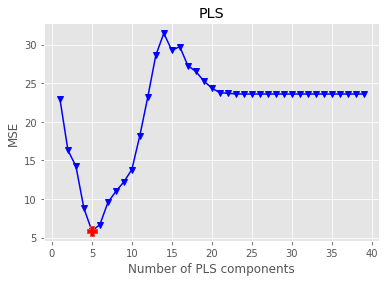

R2 calib: 0.975
R2 CV: 0.928
MSE calib: 2.057
MSE CV: 5.867


In [78]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True) 

R2_pred:  0.5679953425179718
RMSE:  6.5344698532792815



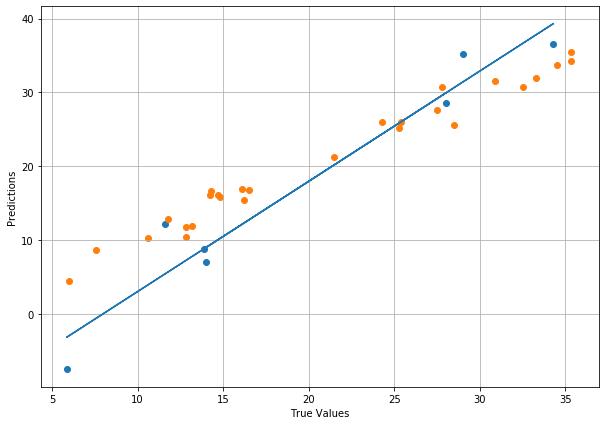

In [80]:
# Define PLS object
pls = PLSRegression(n_components=5)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [60]:
def _calculate_vips(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

In [74]:
a= _calculate_vips(pls)
#print(a)
b=[]
for i in range(len(a)):
    if a[i]> 1.21:
        b.append(i)

x_selecta = pd.DataFrame(x_df.values[:,b])
print(x_selecta.shape)

(34, 304)


In [75]:
print(len(b))

304


In [76]:
x_df.shape

(34, 3648)

In [66]:
x_selecta

0          1          2          3          4          5    \
0  -38.337929   3.660256  19.257166 -12.026150 -10.308770 -12.355886   
1  -42.899587  12.409159  33.146165  -8.232695 -12.634982 -16.290589   
2  -56.930840   6.190993  31.970307  -7.634525 -13.105422 -13.858649   
3  -55.928576  41.211831  74.250918  -5.077189 -28.178051 -39.745564   
4  -41.886001  18.890155  38.096415 -10.840733 -19.504211 -22.254036   
5  -44.953944  14.360060  31.527459  -8.330161 -16.328742 -19.468787   
6  -44.023099  21.890070  40.766690  -7.345028 -19.349860 -25.606016   
7  -44.316361  16.399332  40.071546  -7.187998 -17.666894 -23.130265   
8  -44.561048  26.019780  57.109044  -2.669177 -18.118591 -28.681802   
9  -36.179511   9.361988  22.333274 -13.414222 -16.227874 -19.655163   
10 -53.163534  34.628595  61.518666 -13.035127 -32.675056 -45.227052   
11 -58.104852  18.688391  60.022606 -10.415928 -27.878906 -36.191638   
12 -34.787964 -37.441666  -9.068301 -18.271834  -7.446252  -5.814358   
13 -52.086996 -43.328631 -12.098096 -17.557070  -5.390850   8.592923   
14 -24.767617 -37.806601 -18.264254 -26.237316 -16.334323 -15.126365   
15 -24.134174 -43.497224 -26.010137 -34.853518 -24.289788 -20.858802   
16 -44.992956 -55.938970 -22.593763 -29.026640 -17.422164 -12.677421   
17 -34.301541 -31.524987 -11.839250 -15.749431  -7.440360  -4.306074   
18 -35.838071 -42.081182 -17.231806 -25.644082 -17.138714 -12.727729   
19 -37.186939 -37.613467 -10.755990 -18.292922  -8.686477  -5.767346   
20 -58.492888 -66.283567 -22.203279 -32.976124 -21.608039 -15.472805   
21 -82.397567 -96.337121 -33.176708 -46.558173 -33.471897 -25.982594   
22 -21.246554 -13.143256  -2.352150  -8.231216  -1.857644  -1.149733   
23 -36.605822 -21.348777  -1.555537  -9.465694  -2.485630  -1.130666   
24 -68.719675  40.308001  86.079847 -10.275559 -32.931961 -39.705701   
25 -13.427720  -3.943116  -0.718868  -7.315323  -1.030006  -1.862287   
26 -18.615395  -8.619284  -0.652681  -7.699877  -1.343874  -0.966520   
27 -51.178481   0.150423  23.964054 -17.342986 -22.698785 -28.256247   
28 -17.620721  -7.248435   1.647303  -3.123901   4.496622   5.485878   
29 -15.446517  -5.873652   1.148222  -2.560092   4.646550   6.225948   
30 -31.144349 -13.434267   1.901026  -4.185927   1.226289   4.194622   
31 -21.791258  -8.474710   2.701518  -0.211827   6.672586   8.505473   
32 -32.431505 -15.522287  -1.743287  -6.574770  -0.781305   3.211941   
33 -17.646120  -7.534267   1.555161  -2.737893   4.617768   6.394768   

           6          7          8           9    ...          113  \
0    18.529752 -15.498357 -12.734983  -32.643792  ...  4330.160147   
1    34.691703 -10.636079 -15.704160  -42.078516  ...  5436.796295   
2    47.742563  -2.048012 -10.112500  -35.922723  ...  5112.709734   
3    55.528882 -25.794479 -43.318853  -84.869304  ...  8380.569111   
4    39.701086 -14.667371 -22.047906  -49.002163  ...  6360.316959   
5    30.676593 -16.331014 -20.167121  -44.239319  ...  5843.155440   
6    35.026777 -20.510735 -25.996829  -56.198156  ...  6829.788707   
7    31.581636 -19.404905 -24.925844  -49.580322  ...  6656.296268   
8    38.907952 -21.507558 -31.909810  -65.041729  ...  7146.977798   
9    24.065867 -16.509126 -20.330336  -39.230878  ...  5470.450293   
10   43.970340 -35.117443 -53.462253  -85.943266  ...  8109.754261   
11   39.377806 -30.919342 -41.277805  -75.037243  ...  7151.557338   
12    3.950657  -8.544928   4.538340   -7.655136  ...   617.664609   
13  117.508217  71.946135  46.678731    9.398358  ...   808.176133   
14   -0.265817 -12.765652  -4.011088  -15.854179  ...   629.008886   
15  -11.933345 -26.875295 -14.297038  -30.138877  ...   714.809028   
16   -7.097584 -17.071279  -2.946367  -16.658762  ...   717.844751   
17   -1.036437  -8.037175   2.825192   -7.421079  ...   453.318086   
18   -0.885666 -11.454578  -1.552405  -16.842844  ...   699.591054   
19   -0.585253  -9.389127   1.474722  -10.770024  ...   568.396384   
20   -5.195971 -20.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)

100% completed
Suggested number of components:  6



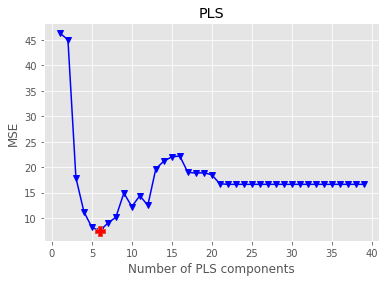

R2 calib: 0.976
R2 CV: 0.911
MSE calib: 2.008
MSE CV: 7.448


In [72]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True) 

In [81]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 15)
#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  9
Wavelengths to be discarded  274
Optimised MSEP  2.7476491863371817

--- 52.21006107330322 seconds ---


sorted wavelengths:  [[226.66 223.44 223.55 219.97 220.32 227.31 216.76 221.4  227.34 224.82]]


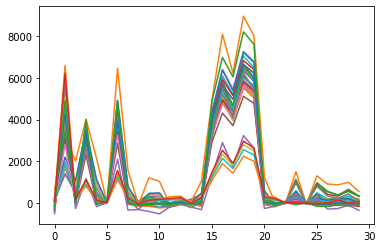

In [82]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [83]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 30) (27, 1)
(7, 30) (7, 1)
       0
2   10.6
8   14.3
12  33.3
13  35.3
9   14.7
3   12.8
27  13.9


50% completed
Suggested number of components:  8



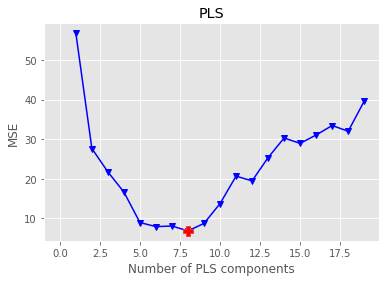

R2 calib: 0.984
R2 CV: 0.918
MSE calib: 1.336
MSE CV: 6.837


In [84]:
optimise_pls_cv(X_train,y_train, 20, plot_components=True)

R2_pred:  0.955794778618041
RMSE:  2.0186136879289167



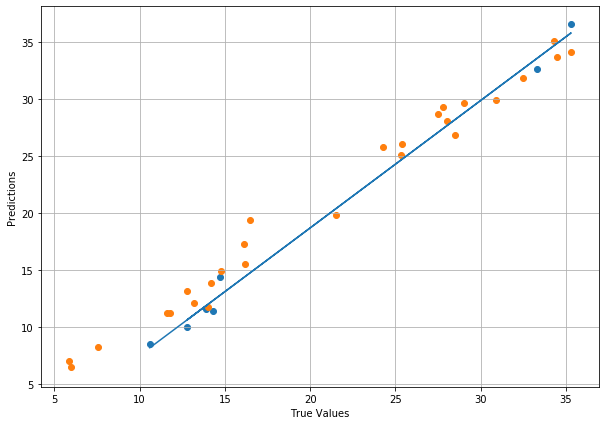

In [86]:
# Define PLS object
pls = PLSRegression(n_components=8)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

Best ones so far:

#1
number_of_population = 150
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.3
threshold_of_variable_selection = 0.6


#2
number_of_population = 150
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.25
threshold_of_variable_selection = 0.5


In [120]:
x_df.shape

(24, 1446)

In [121]:
x_selecta = pd.DataFrame(x_df.values[:,selected_X_variable_numbers])

In [122]:
selected_X_variable_numbers.shape

(87,)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 87) (19, 1)
(5, 87) (5, 1)
        0
9   1.260
23  2.030
12  0.320
3   0.293
4   0.391


# Principal Components Analysis

In [11]:
n_components=20


x = x_df.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 1446)
(1446,)
24
(24, 20)
[32.16 58.34 69.76 79.23 85.78 89.43 91.66 93.69 95.11 96.32 97.1  97.7
 98.23 98.57 98.83 99.08 99.28 99.46 99.61 99.75]


In [12]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation

mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.9848340523115449 -15.14649505941636
0.020707936081303502 22.046798162306988


now using PCA with Linear regression and PLS

In [90]:
n_components=25

x = X_train
x_t = X_test
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 29)
(29,)
19


ValueError: n_components=25 must be between 0 and min(n_samples, n_features)=19 with svd_solver='full'

In [91]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_p = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_p)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_p)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  0.5193224597834807
MSE:  1.2581312388016068


37% completed
Suggested number of components:  2



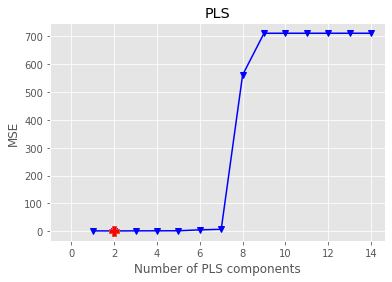

R2 calib: 0.969
R2 CV: 0.099
MSE calib: 0.030
MSE CV: 0.872


In [94]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [100]:
pls = PLSRegression(n_components=2)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  0.5193224597834794
MSE:  1.2581312388016104


# Partial Least Square Regression

In [23]:
print(wl.shape)

(1446,)


## Wavelenght selection for PLS

In [10]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  8
Wavelengths to be discarded  1411
Optimised MSEP  0.39322839374148005

--- 341.1094193458557 seconds ---


sorted wavelengths:  [309.506  399.4131 382.791  291.0649 377.5265 383.387  334.0345 275.32
 333.6584 383.9826]


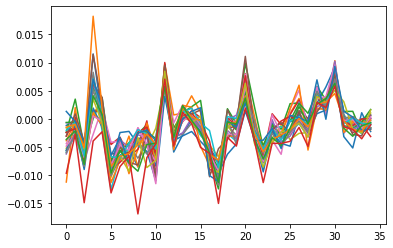

In [11]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [124]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = 3) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 87) (19, 1)
(5, 87) (5, 1)
       0
22  1.11
12  0.32
17  0.39
15  4.54
14  0.77


100% completed
Suggested number of components:  1



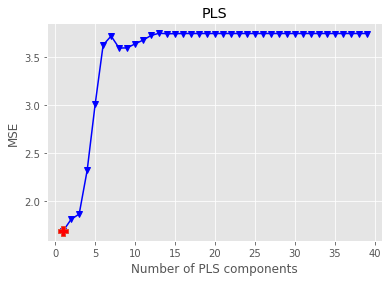

R2 calib: 0.207
R2 CV: -0.638
MSE calib: 0.819
MSE CV: 1.690


In [125]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  -0.5019501966917148
RMSE:  1.9395877766841056



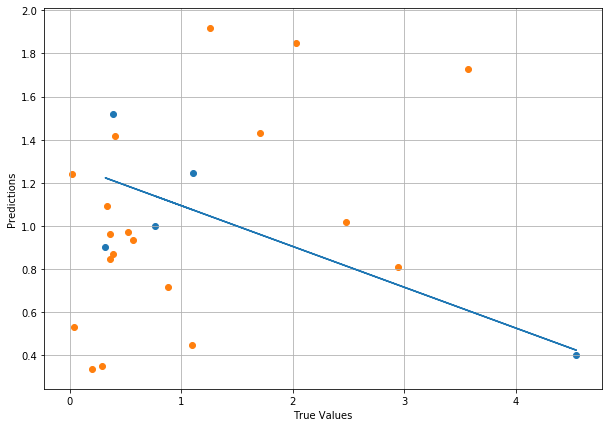

In [128]:
# Define PLS object
pls = PLSRegression(n_components=1)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [51]:
Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)
print(Xn_train.shape)
print(Xn_test.shape)

(27, 1482)
(7, 1482)


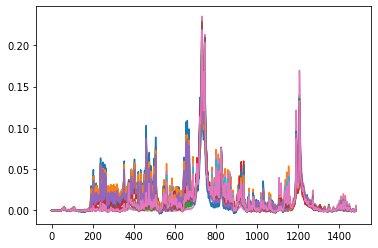

In [52]:
plt.plot(Xn_train.T)
plt.show()

In [53]:
#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xn_train,y_train, 7, plot_components=True)

R2_pred:  0.4893531975724058
RMSE:  3.419987266465691

TEST
 [real, predictions]
[[14.1 18.90831189345998]
 [14.0 17.161365035819625]
 [8.9 9.418279618958724]
 [21.1 16.242784915698614]
 [8.4 7.5474613340348]
 [8.9 13.773935811563382]
 [19.3 19.945657458891404]]



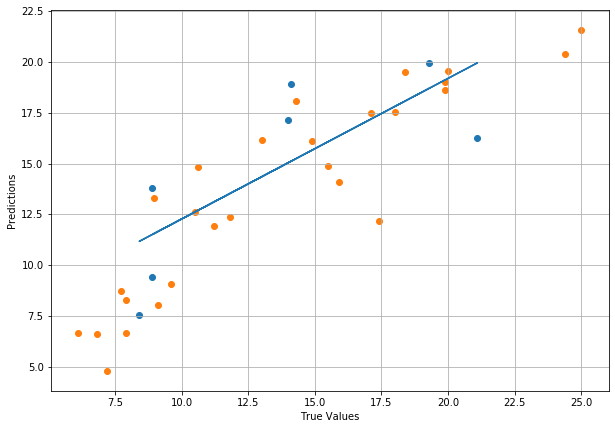

In [55]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using SNV

In [56]:
Xs_train = snv(X_train)
Xs_test = snv(X_test)
print(Xs_train.shape)
print(Xs_test.shape)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xs_train,y_train, 7, plot_components=True)

TypeError: '(0, slice(None, None, None))' is an invalid key

In [134]:
plt.plot(Xs_train.T)
plt.show()

NameError: name 'Xs_train' is not defined

In [135]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(Xs_train, y_train)

y_pred = pls.predict(Xs_test)
y_pred1 = pls.predict(Xs_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

NameError: name 'Xs_train' is not defined

## Using Max-norm

In [69]:
Xm_train = X_train / np.max(X_train,axis=0)
Xm_test = X_test / np.max(X_test,axis=0)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xm_train,y_train, 15, plot_components=True)

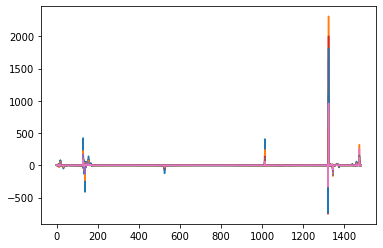

In [70]:
plt.plot(Xm_train.T)
plt.show()

R2_pred:  -64.46537694661592
RMSE:  38.72309102876129

TEST
 [real, predictions]
[[14.1 0.8301553500103029]
 [14.0 23.82754995825756]
 [8.9 -42.45469176187722]
 [21.1 -7.196953938968948]
 [8.4 -10.858422631102878]
 [8.9 7.037827486741614]
 [19.3 -60.7705841095615]]



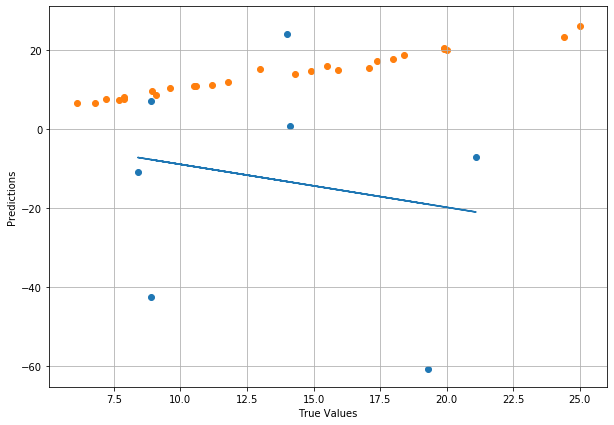

In [71]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(Xm_train, y_train)

y_pred = pls.predict(Xm_test)
y_pred1 = pls.predict(Xm_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)


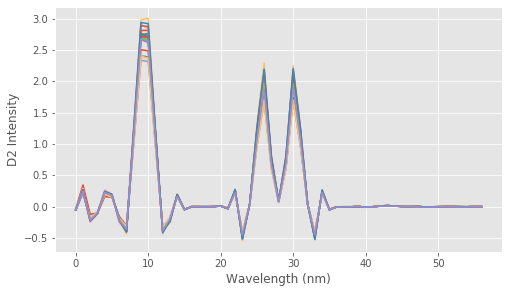

100% completed
Suggested number of components:  8



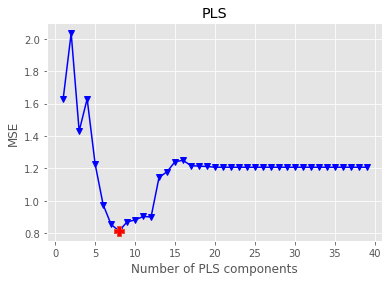

R2 calib: 0.956
R2 CV: 0.404
MSE calib: 0.060
MSE CV: 0.813


In [41]:
# Calculate second derivative
X2 = savgol_filter(opt_Xc, 11, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    

    
optimise_pls_cv(X2, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  1



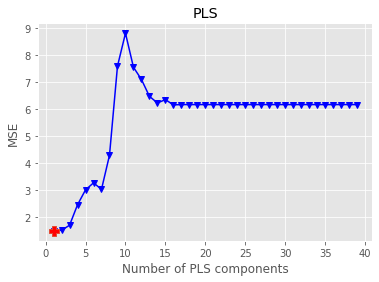

R2 calib: 0.169
R2 CV: -0.027
MSE calib: 1.211
MSE CV: 1.497


In [42]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=1) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=1) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  -2586.547461785336
R2_cv:  -0.690675692387712

[real, predictions]
[[ 3.90000000e-01 -4.48737877e+01]
 [ 2.93000000e-01 -4.61390595e+01]
 [ 2.50000000e-02 -3.88958047e+01]
 [ 2.48000000e+00 -4.94609327e+01]
 [ 3.20000000e-01 -4.45219137e+01]]


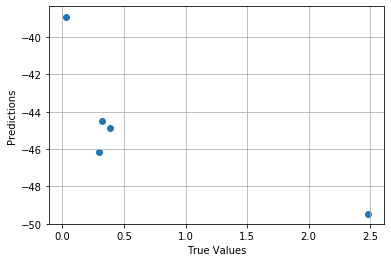

In [43]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(X2_train, y_train)

y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [72]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [73]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:1.00, MSE:33.17, RMSE:5.76
Alpha:0.0010, R2:1.00, MSE:33.05, RMSE:5.75
Alpha:0.0100, R2:1.00, MSE:32.83, RMSE:5.73
Alpha:0.1000, R2:1.00, MSE:35.80, RMSE:5.98
Alpha:0.3000, R2:1.00, MSE:39.47, RMSE:6.28
Alpha:0.5000, R2:1.00, MSE:41.57, RMSE:6.45
Alpha:0.7000, R2:1.00, MSE:41.85, RMSE:6.47
Alpha:1.0000, R2:1.00, MSE:41.13, RMSE:6.41


In [74]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.9999768383309343
RMSE:  5.759070542511677
R^2:  -0.44802625066170787


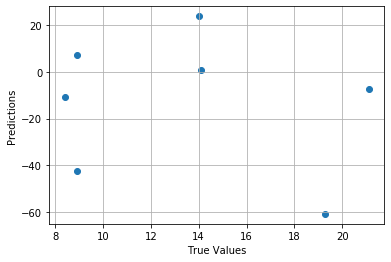

In [75]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [24]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(20, 20) (20, 1)
(4, 20) (4, 1)


In [76]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(7,)
(27,)


RMSE:  3.2004078262978712
R^2:  0.5528200879619326 

[real, predictions]
[[14.1 15.032080000000029]
 [14.0 16.45600000000004]
 [8.9 9.520960000000006]
 [21.1 16.531200000000013]
 [8.4 8.7544]
 [8.9 15.052880000000046]
 [19.3 16.943200000000015]]


Text(0, 0.5, 'Predictions')

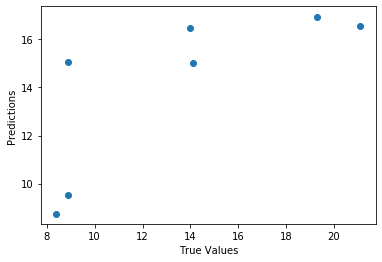

In [78]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 250, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

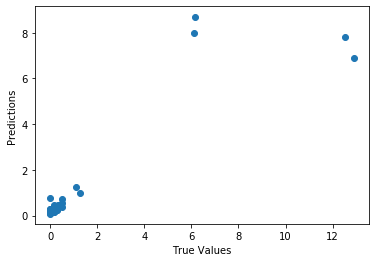

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



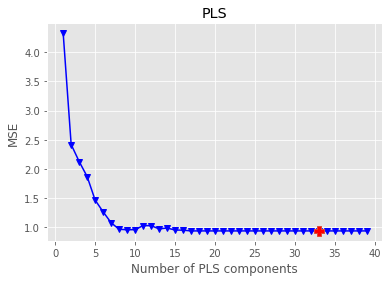

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

0     1     2     3     4     5
0   7.84  0.22  0.54  0.19  0.57  0.27
1   8.62  0.12  0.35  0.06 -0.12 -0.06
2  10.50  0.13 -0.61  0.45  0.15 -0.03
3  -0.28  0.42  1.56 -0.11 -0.34  0.95
4   9.93  0.09  0.29 -0.26  0.65  0.14

In [152]:
np.round(y_test, decimals=2)

0     1     2     3     4     5
20   6.16  0.00  0.36  0.00  0.01  0.21
12   6.12  0.00  0.32  0.00  0.01  0.02
13  12.53  0.31  0.02  0.05  0.06  0.03
22   0.18  0.50  1.11  0.05  0.15  1.26
7   12.90  0.12  0.52  0.16  0.52  0.29